# Richter's Predictor: Modeling Earthquake Damage
Modeling how different variables affect the odds of different damage outcomes to buildings after the 2015 Gorkha earthquake in Nepal

by: <u>Jean-Christophe Gaudreau</u> and <u>Yuri Antonelli</u>

## Necessary Imports and data

Here are the necessary **packages** used in the notebook and the two **files** used to build the models
                        
                       


In [156]:
# Import libraries
install.packages('infotheo')  # Package for information theory calculations
install.packages('keras')  # Package for deep learning models
install.packages("randomForest")  # Package for random forest models
install.packages("gbm")

library(dplyr)  # Data manipulation and transformation
library(ggplot2)  # Data visualization
library(data.table)  # Fast data manipulation
library(infotheo)  # Information theory 
library(rpart)  # Decision tree models
library(gbm) # Gradient Boosting models
library(randomForest)  # Random forest models
library(keras)  # Deep learning models


print('All libraries are loaded')

Warning message:
"package 'infotheo' is in use and will not be installed"
Warning message:
"package 'keras' is in use and will not be installed"
Warning message:
"package 'randomForest' is in use and will not be installed"
Warning message:
"package 'gbm' is in use and will not be installed"


[1] "All libraries are loaded"


In [157]:
trainset=read.csv("train_labels.csv")
trainvalues=read.csv("train_values.csv")

Here the files for the final submission, namely the test set and the submission format.

In [158]:
testset=read.csv("test_values.csv")
subset=read.csv("submission_format.csv")

## Defining functions for "Micro Averaged F1 Score"
Here are the different functions that will be utilized for testing the our predictions (source: MLmetrics library)

In [159]:
ConfusionMatrix <- function(y_pred, y_true) {
  Confusion_Mat <- table(y_true, y_pred)
  return(Confusion_Mat)
}
 
ConfusionDF <- function(y_pred, y_true) {
  Confusion_DF <- transform(as.data.frame(ConfusionMatrix(y_pred, y_true)),
                            y_true = as.character(y_true),
                            y_pred = as.character(y_pred),
                            Freq = as.integer(Freq))
  return(Confusion_DF)
}
 
Precision_micro <- function(y_true, y_pred, labels = NULL) {
  Confusion_DF <- ConfusionDF(y_pred, y_true)
 
  if (is.null(labels) == TRUE) labels <- unique(c(y_true, y_pred))
  # this is not bulletproof since there might be labels missing (in strange cases)
  # in strange cases where they existed in training set but are missing from test ground truth and predictions.
 
  TP <- c()
  FP <- c()
  for (i in c(1:length(labels))) {
    positive <- labels[i]
   
    # it may happen that a label is never predicted (missing from y_pred) but exists in y_true
    # in this case ConfusionDF will not have these lines and thus the simplified code crashes
    # TP[i] <- as.integer(Confusion_DF[which(Confusion_DF$y_true==positive & Confusion_DF$y_pred==positive), "Freq"])
    # FP[i] <- as.integer(sum(Confusion_DF[which(Confusion_DF$y_true!=positive & Confusion_DF$y_pred==positive), "Freq"]))
   
    # workaround:
    # i don't want to change ConfusionDF since i don't know if the current behaviour is a feature or a bug.
    tmp <- Confusion_DF[which(Confusion_DF$y_true==positive & Confusion_DF$y_pred==positive), "Freq"]
    TP[i] <- if (length(tmp)==0) 0 else as.integer(tmp)
   
    tmp <- Confusion_DF[which(Confusion_DF$y_true!=positive & Confusion_DF$y_pred==positive), "Freq"]
    FP[i] <- if (length(tmp)==0) 0 else as.integer(sum(tmp))
  }
  Precision_micro <- sum(TP) / (sum(TP) + sum(FP))
  return(Precision_micro)
}
 
Recall_micro <- function(y_true, y_pred, labels = NULL) {
  Confusion_DF <- ConfusionDF(y_pred, y_true)
 
  if (is.null(labels) == TRUE) labels <- unique(c(y_true, y_pred))
  # this is not bulletproof since there might be labels missing (in strange cases)
  # in strange cases where they existed in training set but are missing from test ground truth and predictions.
 
  TP <- c()
  FN <- c()
  for (i in c(1:length(labels))) {
    positive <- labels[i]
   
    # short version, comment out due to bug or feature of Confusion_DF
    # TP[i] <- as.integer(Confusion_DF[which(Confusion_DF$y_true==positive & Confusion_DF$y_pred==positive), "Freq"])
    # FP[i] <- as.integer(sum(Confusion_DF[which(Confusion_DF$y_true==positive & Confusion_DF$y_pred!=positive), "Freq"]))
   
    # workaround:
    tmp <- Confusion_DF[which(Confusion_DF$y_true==positive & Confusion_DF$y_pred==positive), "Freq"]
    TP[i] <- if (length(tmp)==0) 0 else as.integer(tmp)
 
    tmp <- Confusion_DF[which(Confusion_DF$y_true==positive & Confusion_DF$y_pred!=positive), "Freq"]
    FN[i] <- if (length(tmp)==0) 0 else as.integer(sum(tmp))
  }
  Recall_micro <- sum(TP) / (sum(TP) + sum(FN))
  return(Recall_micro)
}
 
F1_Score_micro <- function(y_true, y_pred, labels = NULL) {
  if (is.null(labels) == TRUE) labels <- unique(c(y_true, y_pred)) # possible problems if labels are missing from y_*
  Precision <- Precision_micro(y_true, y_pred, labels)
  Recall <- Recall_micro(y_true, y_pred, labels)
  F1_Score_micro <- 2 * (Precision * Recall) / (Precision + Recall)
  return(F1_Score_micro)
}

## 1. Data preprocessing pipeline

Let's first implement a preprocessing pipeline to remove unecessary data and filter categorical data.

First of all let's take a look to our data.

In [160]:
head(trainset)
head(trainvalues)

,building_id,damage_grade
,<int>,<int>
1,802906,3
2,28830,2
3,94947,3
4,590882,2
5,201944,3
6,333020,2


,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,⋯,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,802906,6,487,12198,2,30,6,5,t,r,⋯,0,0,0,0,0,0,0,0,0,0
2,28830,8,900,2812,2,10,8,7,o,r,⋯,0,0,0,0,0,0,0,0,0,0
3,94947,21,363,8973,2,10,5,5,t,r,⋯,0,0,0,0,0,0,0,0,0,0
4,590882,22,418,10694,2,10,6,5,t,r,⋯,0,0,0,0,0,0,0,0,0,0
5,201944,11,131,1488,3,30,8,9,t,r,⋯,0,0,0,0,0,0,0,0,0,0
6,333020,8,558,6089,2,10,9,5,t,r,⋯,1,0,0,0,0,0,0,0,0,0


Our target variable, namely **"damage_grade"**, matches with the features dataset via **"building_id"** column, let's then make a left join to work on a single dataset.

In [161]:
# Generating a "master" dataset to use
# Matching Label data to Values data to have as many datapoints for both CSVs
master <- left_join(y=trainset,x=trainvalues,by="building_id",all.x=TRUE)
# Check if we have any missing data
sum(is.na(master))

[1] 0

###  1.1 Data Visualization 
First and foremost, let us examine the distribution of our variable of interest.

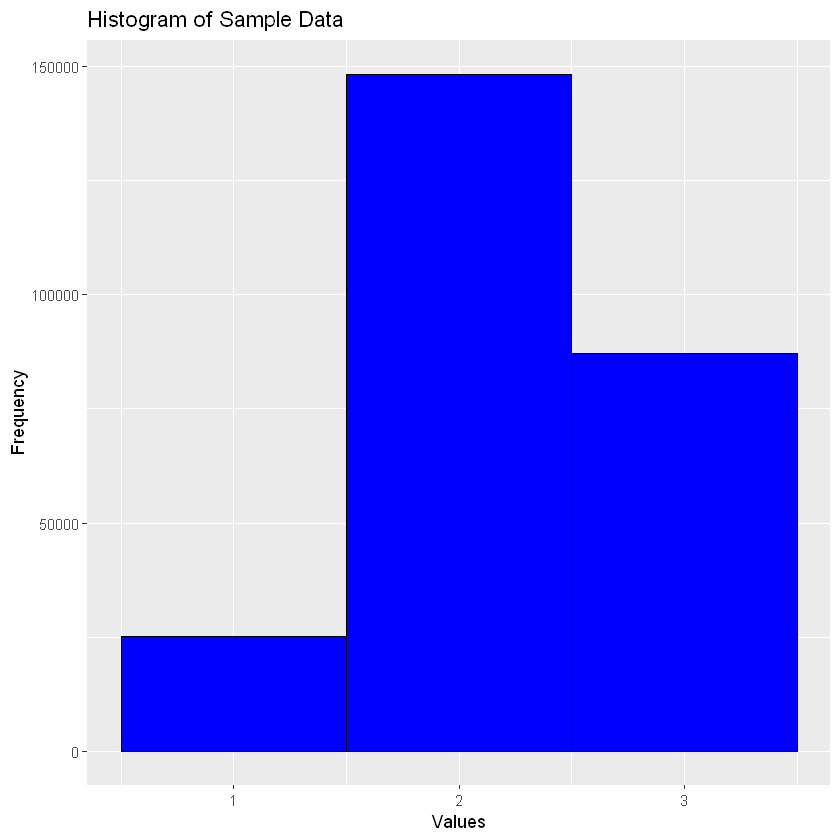

In [162]:
ggplot(master, aes(x = damage_grade)) + 
  geom_histogram(binwidth = 1, fill = "blue", color = "black") + 
  ggtitle("Histogram of Sample Data") + 
  xlab("Values") + 
  ylab("Frequency")

Upon observing the graph, it is evident that the classes exhibit significant imbalance. This class imbalance may result in the machine learning classifier displaying bias towards the majority class, leading to inadequate classification of the minority class.

Considering that one of the algorithms we intend to utilize is Random Forest, let us proceed to implement code for generating various weights to be employed in the "classwt" hyperparameter of the model. 

This code snippet calculates weights for each class by taking the inverse of the absolute frequency and subsequently normalizing them to ensure their summation equals 1.

In [163]:
# weigths to deal with unbalancedness in the random forest algorithm
class_frequencies <- table(trainset$damage_grade)
class_weights <- 1 / class_frequencies
classwt <- class_weights / sum(class_weights)
classwt


        1         2         3 
0.6860969 0.1162661 0.1976369 

The next issue that requires attention pertains to the geo_level_variables. These variables exhibit an extensive range of values, and encoding them all using one-hot encoding would significantly inflate the size of the feature space.

Let us examine if any discernible patterns exist among these variables that can be leveraged for feature engeenering.

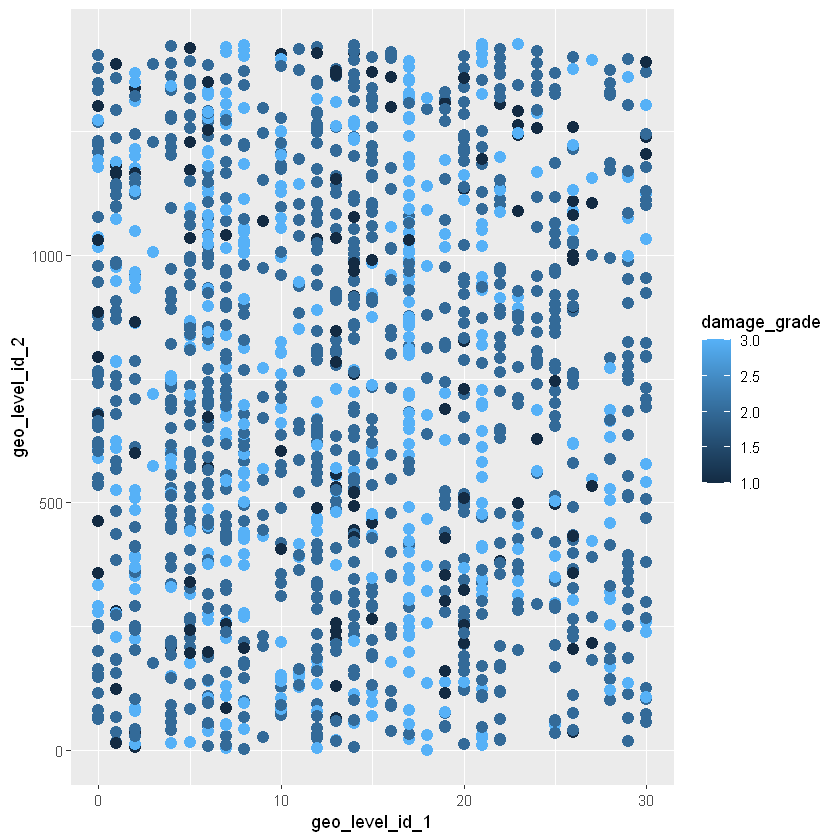

In [164]:
# geo_level_id_1 & geo_level_2_id using damage_grade (our target) as 3rd dimension
ggplot(data = master, aes(x = geo_level_1_id, y = geo_level_2_id, color = damage_grade)) +
  geom_point(size = 3) +
  labs(x = "geo_level_id_1", y = "geo_level_id_2", color = "damage_grade")

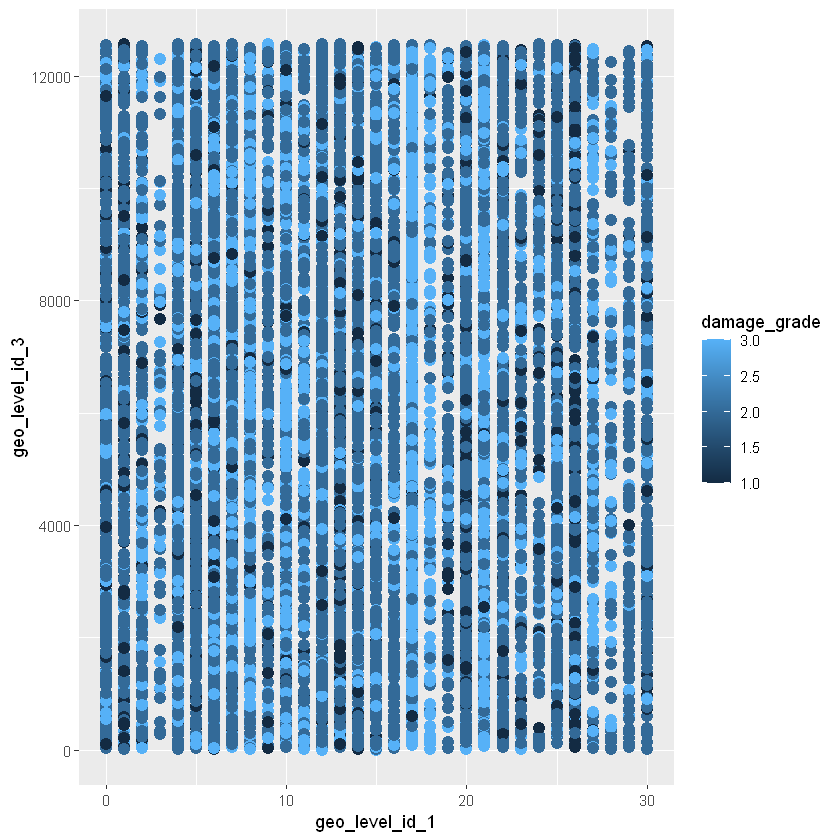

In [165]:
ggplot(data = master, aes(x = geo_level_1_id, y = geo_level_3_id, color = damage_grade)) +
  geom_point(size = 3) +
  labs(x = "geo_level_id_1", y = "geo_level_id_3", color = "damage_grade")

Based on our observation, it appears that no distinct pattern can be identified for the purpose of feature engineering. Consequently, we shall proceed with the one-hot encoding of the variable "geo_level_id_1," as it possesses a reasonable number of unique values.

Lastly, let us analyze the distribution of all the numerical variables in our dataset to ascertain the presence of any outliers.

In [166]:
str(master)

'data.frame':	260601 obs. of  40 variables:
 $ building_id                           : int  802906 28830 94947 590882 201944 333020 728451 475515 441126 989500 ...
 $ geo_level_1_id                        : int  6 8 21 22 11 8 9 20 0 26 ...
 $ geo_level_2_id                        : int  487 900 363 418 131 558 475 323 757 886 ...
 $ geo_level_3_id                        : int  12198 2812 8973 10694 1488 6089 12066 12236 7219 994 ...
 $ count_floors_pre_eq                   : int  2 2 2 2 3 2 2 2 2 1 ...
 $ age                                   : int  30 10 10 10 30 10 25 0 15 0 ...
 $ area_percentage                       : int  6 8 5 6 8 9 3 8 8 13 ...
 $ height_percentage                     : int  5 7 5 5 9 5 4 6 6 4 ...
 $ land_surface_condition                : chr  "t" "o" "t" "t" ...
 $ foundation_type                       : chr  "r" "r" "r" "r" ...
 $ roof_type                             : chr  "n" "n" "n" "n" ...
 $ ground_floor_type                     : chr  "f" "x" "f" "

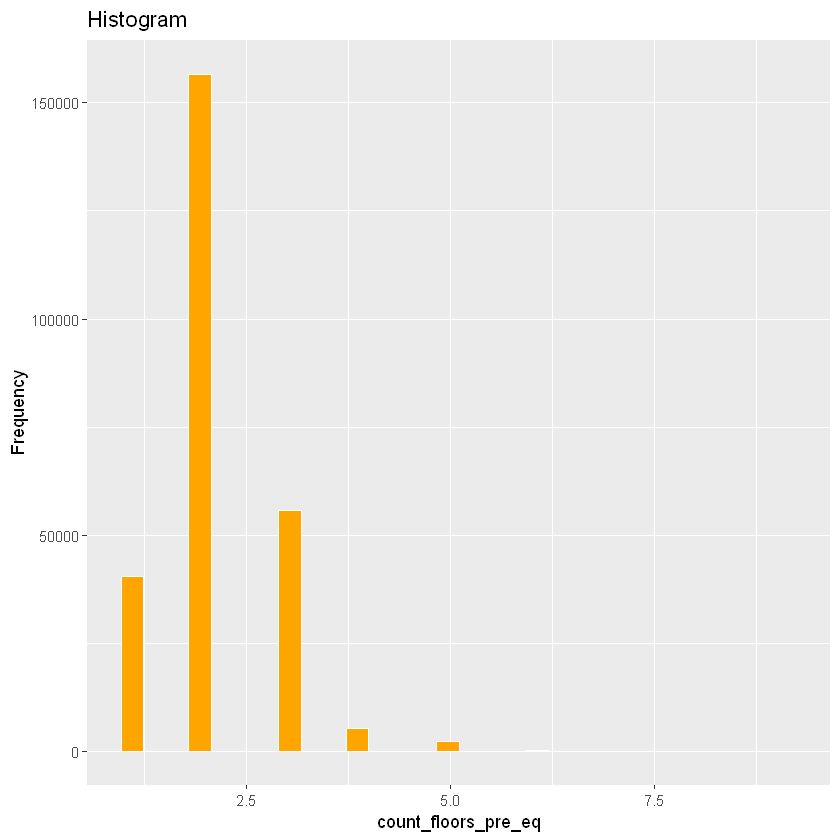

In [167]:
ggplot(data = master, aes(x = count_floors_pre_eq)) +
  geom_histogram(fill = "orange", color = "white", bins = 30) +
  labs(x = "count_floors_pre_eq", y = "Frequency", title = "Histogram")

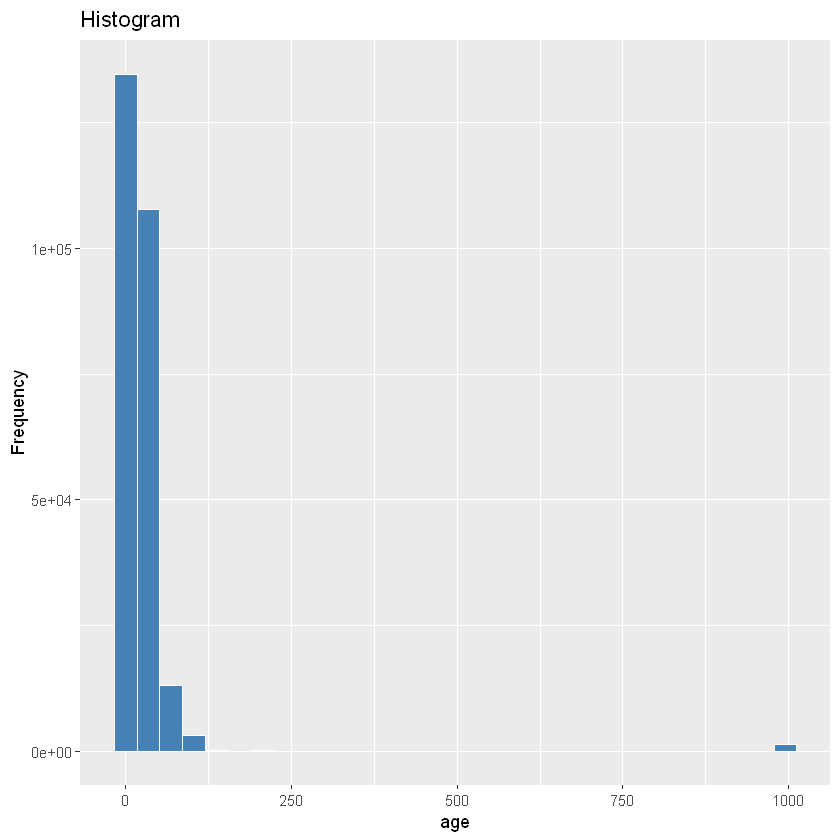

In [168]:
ggplot(data = master, aes(x = age)) +
  geom_histogram(fill = "steelblue", color = "white", bins = 30) +
  labs(x = "age", y = "Frequency", title = "Histogram")

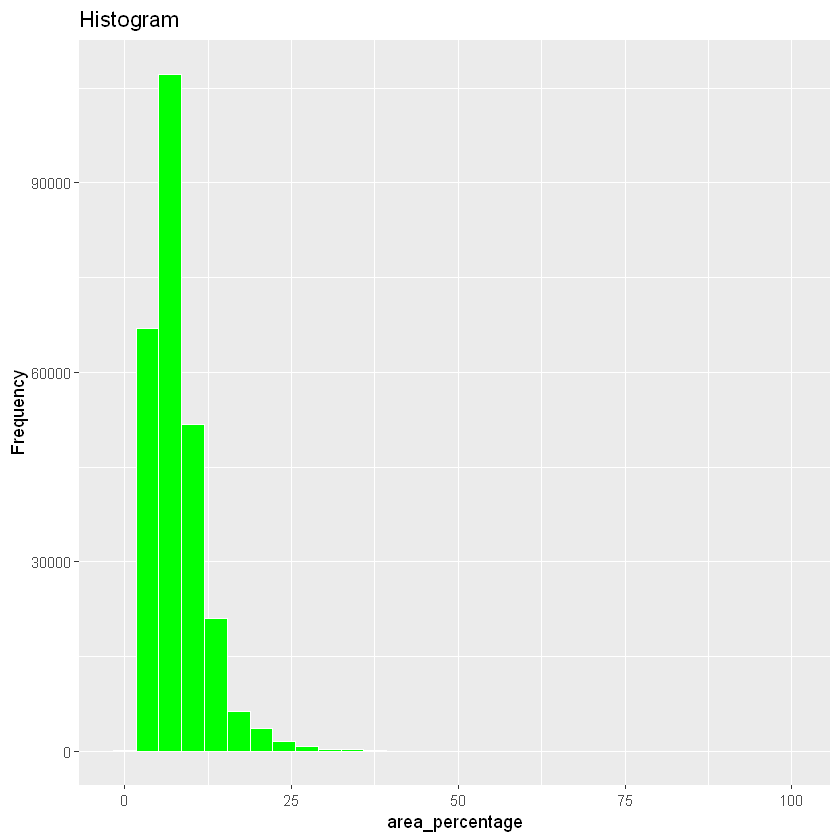

In [169]:
ggplot(data = master, aes(x = area_percentage)) +
  geom_histogram(fill = "green", color = "white", bins = 30) +
  labs(x = "area_percentage", y = "Frequency", title = "Histogram")

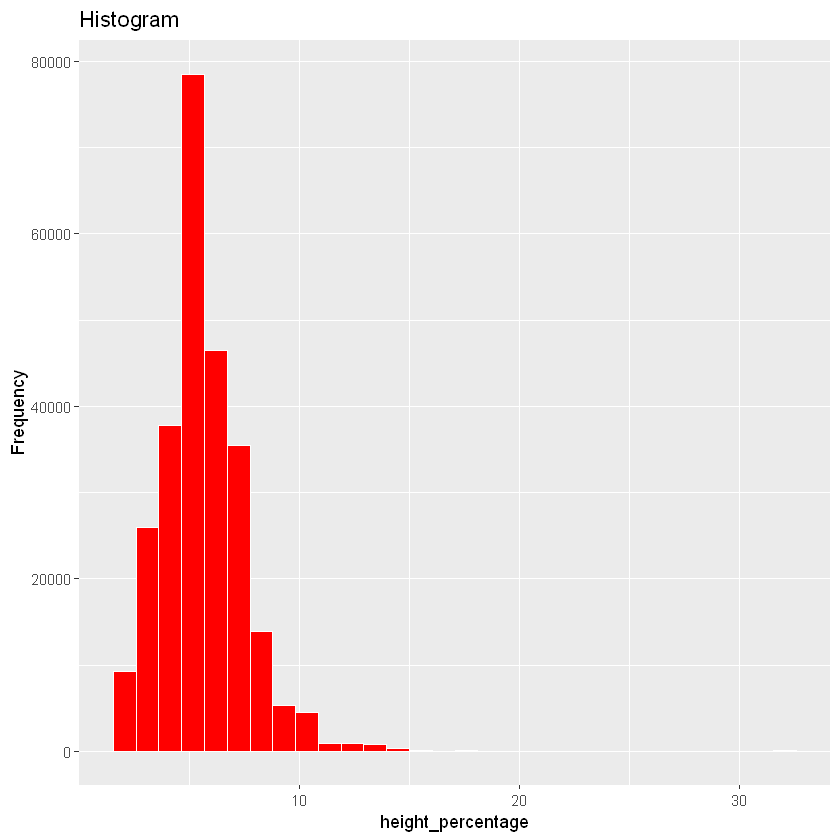

In [170]:
ggplot(data = master, aes(x = height_percentage)) +
  geom_histogram(fill = "red", color = "white", bins = 30) +
  labs(x = "height_percentage", y = "Frequency", title = "Histogram")

The dataset appears to be clean and reasonable, with no percentages exceeding the limit of 100%. Although there is one extreme value indicating a building approximately 1000 years old, it is plausible and thus we will keep it in the dataset.

In order to obtain a better comprehension, let's proceed by creating a summary of the numerical variables within the dataset.

In [171]:
num_var = c('count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage')

summary(master[num_var])

 count_floors_pre_eq      age         area_percentage   height_percentage
 Min.   :1.00        Min.   :  0.00   Min.   :  1.000   Min.   : 2.000   
 1st Qu.:2.00        1st Qu.: 10.00   1st Qu.:  5.000   1st Qu.: 4.000   
 Median :2.00        Median : 15.00   Median :  7.000   Median : 5.000   
 Mean   :2.13        Mean   : 26.54   Mean   :  8.018   Mean   : 5.434   
 3rd Qu.:2.00        3rd Qu.: 30.00   3rd Qu.:  9.000   3rd Qu.: 6.000   
 Max.   :9.00        Max.   :995.00   Max.   :100.000   Max.   :32.000   

### 1.2 Transforming categorical data into binary encoding (One-Hot)

List of all the categorical variables to be one-hot encoded.

In [172]:
cat_cols=c('land_surface_condition', 'foundation_type',"roof_type","ground_floor_type",
"other_floor_type","position","plan_configuration","legal_ownership_status","geo_level_1_id","geo_level_2_id","geo_level_3_id")
head(master[cat_cols])

,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,legal_ownership_status,geo_level_1_id,geo_level_2_id,geo_level_3_id
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>
1,t,r,n,f,q,t,d,v,6,487,12198
2,o,r,n,x,q,s,d,v,8,900,2812
3,t,r,n,f,x,t,d,v,21,363,8973
4,t,r,n,f,x,s,d,v,22,418,10694
5,t,r,n,f,x,s,d,v,11,131,1488
6,t,r,n,f,q,s,d,v,8,558,6089


Here, we have a list of all available categorical data. Although geo_level IDs are integers, they are also considered as categorical since each IDs represents a different house, and there is no visible linear behavior between each ID. Therefore, we can encode <u>**geo_level_1_id**</u> with One-hot without encountering difficulties with the dimensions of our dataset ($\approx$ 30 columns). We decided to leave out <u>**geo_level_id 2-3**</u> due to this complexity problem.

In [173]:
#One-Hot encoding categorical data without geo_level_2 and 3
cat_cols=c('land_surface_condition', 'foundation_type',"roof_type","ground_floor_type",
"other_floor_type","position","plan_configuration","legal_ownership_status","geo_level_1_id")
# use dummyVars function to create binary encoding for categorical variables
encode_categorical_variables <- function(dataset, cat_cols,remove_columns = NULL) {
  # Create a copy of the dataset for encoding
  encoded_dataset <- dataset
  # Loop through the categorical columns and encode each column
  for (col in cat_cols) {
    dict <- unique(dataset[[col]])
    binary_matrix <- matrix(0L, nrow = nrow(dataset), ncol = length(dict))
    for (i in 1:length(dict)) {
      binary_matrix[dataset[[col]] == dict[i], i] <- 1L
    }
    colnames(binary_matrix) <- paste0(col, "_", dict)
    encoded_dataset <- cbind(encoded_dataset, binary_matrix)
  }
  
  # Remove the original categorical columns from the new dataframe
  encoded_dataset <- encoded_dataset[, !colnames(encoded_dataset) %in% cat_cols]
  encoded_dataset <- encoded_dataset[, !colnames(encoded_dataset) %in% remove_columns]
  return(encoded_dataset)
}

## Encoding numerical variables
A function to normalize some columns could be useful for models that require all variables to oscillate between 0-1 (Neural-networks)

In [174]:
encode_numerical_variables <- function(data, columns) {
  for (col in columns) {
    # Retrieve the column values
    values <- data[[col]]
    
    # Apply min-max scaling to normalize the values between 0 and 1
    normalized_values <- (values - min(values)) / (max(values) - min(values))
    
    # Replace the column values with normalized values
    data[[col]] <- normalized_values
  }
  
  return(data)
}

In [175]:
#Encoding original dataset
encoded_train <- encode_categorical_variables(master,cat_cols,c("geo_level_2_id","geo_level_3_id"))
head(encoded_train)

,building_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,⋯,geo_level_1_id_5,geo_level_1_id_15,geo_level_1_id_14,geo_level_1_id_19,geo_level_1_id_1,geo_level_1_id_24,geo_level_1_id_28,geo_level_1_id_23,geo_level_1_id_2,geo_level_1_id_29
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,802906,2,30,6,5,1,1,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2,28830,2,10,8,7,0,1,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
3,94947,2,10,5,5,0,1,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
4,590882,2,10,6,5,0,1,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
5,201944,3,30,8,9,1,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
6,333020,2,10,9,5,0,1,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


### 1.3 Feature Selection
Given the dataset's extensive number of variables, it is crucial to select the most relevant ones for our specific problem. To accomplish this, we employ a ranking algorithm based on the mutual information criterion. This criterion allows us to identify the variables that exhibit the highest information gain and are thus most informative for our analysis.

In [176]:
# delete useless columns for the ranking
df_train2 = copy(encoded_train)
df_train2$building_id = NULL
df_train2$damage_grade = NULL
df_train2$geo_level_2_id = NULL
df_train2$geo_level_3_id = NULL

# dataframe to store the results
mi_df = data.frame(matrix(nrow = length(colnames(df_train2)), ncol = 1))
rownames(mi_df) = colnames(df_train2)
colnames(mi_df) = 'Mutual_Information'

# compute mutual information for each variable and fill the dataframe
for (i in 1:length(df_train2)){
    a = mutinformation(df_train2[ ,i], encoded_train$damage_grade)
    mi_df[i, 1] = a
    mi_df <- arrange(mi_df, desc(Mutual_Information))
    
}

# results
head(mi_df)

,Mutual_Information
,<dbl>
foundation_type_r,0.06294687
ground_floor_type_v,0.05233678
has_superstructure_mud_mortar_stone,0.04921463
geo_level_1_id_17,0.04396153
roof_type_x,0.03997262
foundation_type_i,0.03549682


## 2. Model Training
In this section, our objective is to train various models using different sets of features to determine the optimal approach for addressing our problem. Leveraging the previously created feature ranking, we will gradually incorporate one feature at a time and evaluate the performance of the models.

We will utilize three models, progressing from the simplest to the most complex:
1. *Decision Tree*
2. *Random Forest*
3. *Neural Network*

Due to the dataset's extensive dimensionality, we will evaluate the models using a classic train-validation split, as performing cross-validation would be computationally expensive. To mitigate the lengthy computational time, we will train the models on approximately **5000 observations** and reserve the remaining data for testing. Based on our findings, this split does not significantly compromise the performance compared to utilizing a larger training dataset.

Please note that this procedure requires substantial running time, given the size of the dataset and the complexity of the models involved.

In [177]:
# Train-Test split
train_prop = 0.05 # 5000 observations

# calculate the number of rows to use for training
train_size <- round(nrow(encoded_train) * train_prop)

# Shuffle the rows of the dataset
set.seed(123)
data_shuffled <- encoded_train[sample(nrow(encoded_train)),]

# Split the shuffled data into training and test sets
train_data <- data_shuffled[1:train_size,]
test_data <- data_shuffled[(train_size+1):nrow(data_shuffled),]

# results
head(train_data)
dim(train_data)
head(test_data)
dim(test_data)

,building_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,⋯,geo_level_1_id_5,geo_level_1_id_15,geo_level_1_id_14,geo_level_1_id_19,geo_level_1_id_1,geo_level_1_id_24,geo_level_1_id_28,geo_level_1_id_23,geo_level_1_id_2,geo_level_1_id_29
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
182735,23555,2,10,12,5,0,1,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
188942,848406,3,50,7,6,0,1,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
134058,562045,2,10,22,7,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
124022,491150,2,80,9,5,0,1,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
160997,12219,2,20,10,4,0,1,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
226318,880155,2,0,6,5,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


[1] 13030    98

,building_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,⋯,geo_level_1_id_5,geo_level_1_id_15,geo_level_1_id_14,geo_level_1_id_19,geo_level_1_id_1,geo_level_1_id_24,geo_level_1_id_28,geo_level_1_id_23,geo_level_1_id_2,geo_level_1_id_29
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
243101,791583,2,30,4,6,0,1,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
165658,824476,2,0,5,5,0,1,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
60944,1001918,2,5,8,5,1,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
139402,89590,2,15,9,5,0,1,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
216132,546127,1,10,3,2,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
230133,869582,2,20,8,4,0,1,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


[1] 247571     98

The core function for training operates as follows:

It accepts three inputs:

- The maximum number of features to include.
- The model to train, specified as either "dec_tree" for Decision Tree "rand_for" for Random Forest, or "grad_boosting" for Gradient Boosting.
- An additional parameter, "train_jump," introduced to optimize the algorithm. 

For a given maximum number of features (N), this algorithm trains N different models. In particular, when "train_jump" is set, it allows training the model by excluding intermediate steps. For instance, if "train_jump" is 5 and the maximum number of features (max_n) is 50, the model will be trained on the best 5 features, then the best 10 features, and so on, until reaching 50.

The function's final output is a dual plot of the F1_Score_micro metric for both the train and test sets.

In [178]:
training = function(max_n, model, train_jump=1){
    max_n_features = max_n
    my_index <- which(colnames(train_data) == "damage_grade")
    names = rownames(mi_df)

    # create the dataframe
    indexes_features = c()
    performance_df = data.frame(matrix(nrow = max_n_features, ncol = 2))
    colnames(performance_df) = c('train_perf', 'test_perf')
    rownames(performance_df) = 1:max_n_features

    for (i in 1:max_n_features){
        n = which(colnames(train_data) == names[i])
        indexes_features[i] = n
        train = train_data[ ,indexes_features]
        test = test_data[ ,indexes_features]
        train$damage_grade = as.factor(as.character(train_data$damage_grade))
        test$damage_grade = as.factor(as.character(test_data$damage_grade))
        
        if (i %in% seq(2, max_n_features, by=train_jump) ){
            if (model == 'dec_tree'){
                # Train a decision tree model on the training data
                tree_model <- rpart(damage_grade ~ ., data = train)

                # Predict the labels for the training and test sets
                train_pred <- predict(tree_model, train, type = "class")
                test_pred <- predict(tree_model, test_data, type = "class")

                # Calculate the accuracy of the model on the training and test sets
                train_acc <- F1_Score_micro(train$damage_grade, train_pred)
                test_acc <- F1_Score_micro(test$damage_grade, test_pred)

                # store the results
                performance_df[i, 1] = train_acc
                performance_df[i, 2] = test_acc 
            }
            if (model == 'rand_for'){
                # Train a decision tree model on the training data
                set.seed(123)
                rf_model <- randomForest(damage_grade ~ ., data = train, ntree = 100, classwt=classwt)

                # Predict the labels for the training and test sets
                train_pred <- predict(rf_model, newdata = train[ ,1:i])
                test_pred <- predict(rf_model, newdata = test)

                # Calculate the accuracy of the model on the training and test sets
                train_acc = F1_Score_micro(train$damage_grade, train_pred)
                test_acc = F1_Score_micro(test$damage_grade, test_pred)

                # store the results
                performance_df[i, 1] = train_acc
                performance_df[i, 2] = test_acc 
            }
            if (model == 'grad_boosting'){
                # Train gradient boosting gradient boosting
                set.seed(123)
                gbm_model <- gbm(damage_grade ~ ., data = train, distribution = "multinomial", n.trees = 100, interaction.depth = 3, shrinkage = 0.1)

                # Accuracy 
                pred1 = predict.gbm(object = gbm_model,
                                newdata = train,
                                n.trees = 100,           
                                type = "response")

                pred2 = predict.gbm(object = gbm_model,
                                newdata = test,
                                n.trees = 100,           
                                type = "response")

                labels1 = colnames(pred1)[apply(pred1, 1, which.max)]
                labels2 = colnames(pred2)[apply(pred2, 1, which.max)]

                result1 = data.frame(train_data$building_id, labels1)
                result2 = data.frame(test_data$building_id, labels2)

                train_acc <- F1_Score_micro(train$damage_grade, result1$labels1)
                test_acc <- F1_Score_micro(test$damage_grade, result2$labels2)

                # store the results
                performance_df[i, 1] = train_acc
                performance_df[i, 2] = test_acc 
            }
        }
    }
    performance_df = na.omit(performance_df) 
    ggplot(performance_df, aes(x = as.numeric(rownames(performance_df)))) +
    geom_line(aes(y = train_perf, color = "Train Performance")) +
    geom_line(aes(y = test_perf, color = "Test Performance")) +
    labs(x = "X-labels", y = "Performance") +
    scale_color_manual(values = c("Train Performance" = "blue", "Test Performance" = "red")) +
    theme_minimal()
}

## 2.1 Decision Tree


One approach to address this classification problem is by utilizing a simple Decision Tree model.

Warning message in train$damage_grade <- as.factor(as.character(train_data$damage_grade)):
"Coercing LHS to a list"
Warning message in test$damage_grade <- as.factor(as.character(test_data$damage_grade)):
"Coercing LHS to a list"


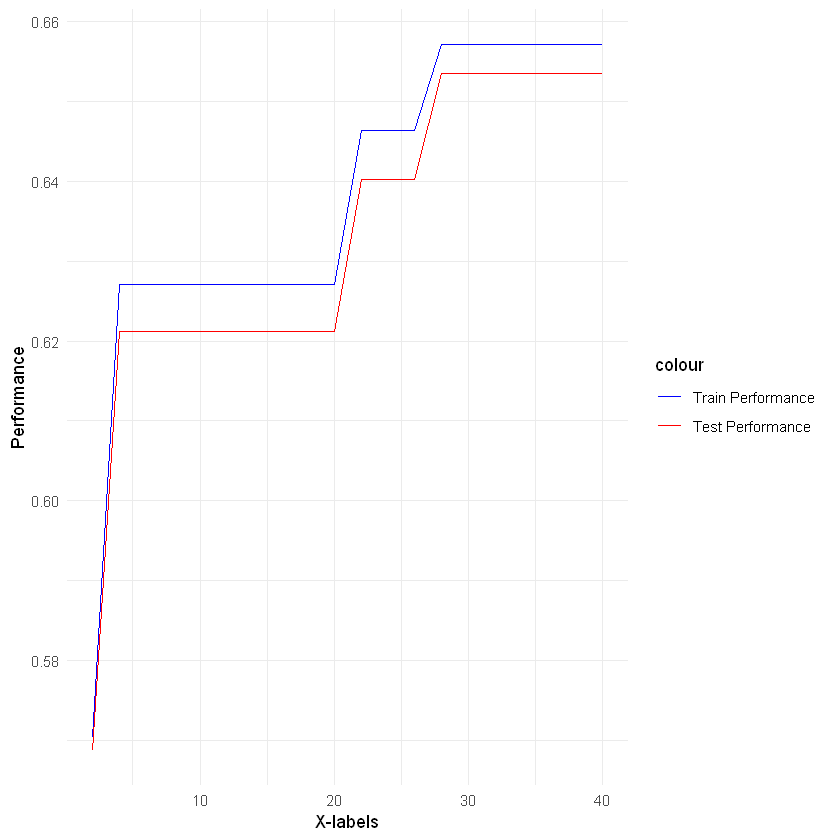

In [179]:
training(40,"dec_tree",2)

Upon examining the graph, it is evident that the Decision Tree model demonstrates excellent performance. Remarkably, even when utilizing 40 features, there are no apparent signs of overfitting. However, it is worth noting that the marginal improvement in performance becomes nearly insignificant after including the first 5 features.

This observation suggests that the Decision Tree model is capable of achieving high accuracy with a limited number of informative features.

## 2.2 Random Forest

The second algorithm we employ is Random Forest. However, it is important to note that we train a balanced Random Forest by adjusting the weights in the **"classwt"** hyperparameter. This approach aims to address class imbalance and promote a fair representation of minority classes in the model.

It is worth mentioning that using balanced weights in Random Forest may slightly decrease the overall performance of the classifier. 

However, the trade-off for this reduction in performance is enhanced interpretability of the model. Consequently, we reserve the use of this classifier towards the end of the project for the purpose of **conditional entropy ranking**.

Warning message in train$damage_grade <- as.factor(as.character(train_data$damage_grade)):
"Coercing LHS to a list"
Warning message in test$damage_grade <- as.factor(as.character(test_data$damage_grade)):
"Coercing LHS to a list"


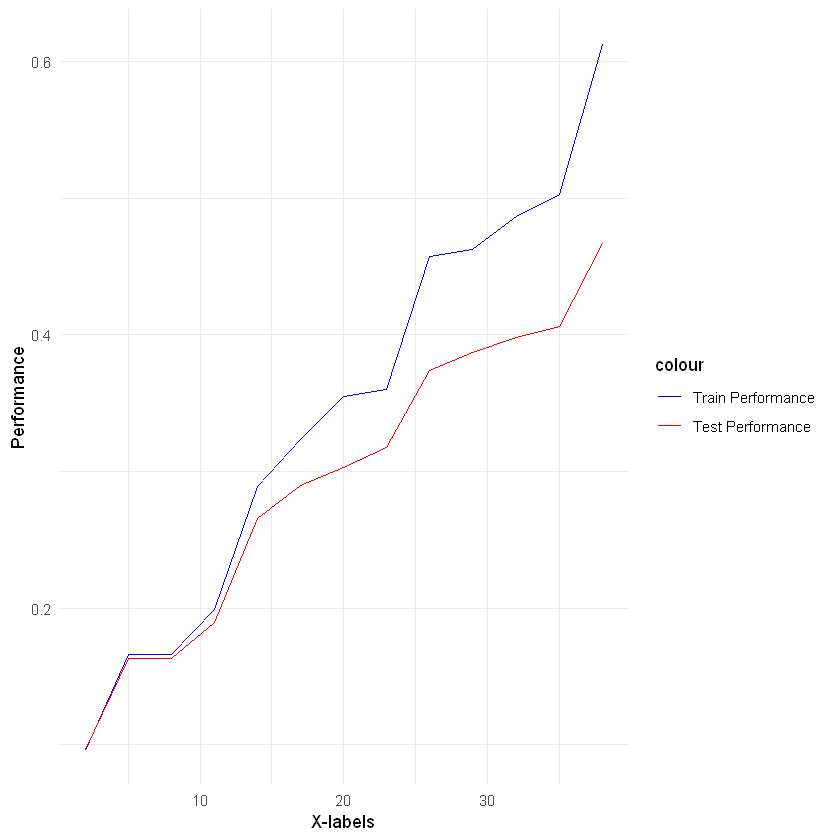

In [180]:
training(40, 'rand_for', 3)

As anticipated, the Random Forest model exhibits a slightly lower performance compared to a single Decision Tree. 

The higher jaggedness of the curves in the performance plot and  the absence of a plateau in performance improvement though,suggests that the Random Forest model may continue to benefit from additional features.

While the Random Forest model may not achieve the same level of accuracy as a single Decision Tree, its strength lies in its enhanced explainability, particularly in scenarios with class imbalances. 

## 2.3 Neural-Network
Here, we decided to implement a neural network with 4 layers. The first layer being the **input** layer, the second being the 2 **hidden** layers and the third the **outputs** layer (from 0-2) since keras builds models that start at zero.
Ps: Most of the information is given inside the <u>train_and_save_model_NN</u> function


In [181]:
train_and_save_model_NN <- function(dataset, save_path) {
  cat_cols=c('land_surface_condition', 'foundation_type',"roof_type","ground_floor_type",
  "other_floor_type","position","plan_configuration","legal_ownership_status","geo_level_1_id")
  # Remove unnecessary columns from the dataset using the function above (preprocessing) and encode categorical and numerical data
  dataset <- encode_categorical_variables(dataset,cat_cols,c("geo_level_2_id","geo_level_3_id"))

  dataset <- encode_numerical_variables(dataset,c("count_floors_pre_eq","age","area_percentage","height_percentage"))
  dataset$building_id <- NULL
  
  # Prepare the data for training
  # 1. Making sure the independant variables x are given as a matrix, i.e. the right input for keras's neural networks
  # 2. Making sure y (damage_grade) is given to the model starting at zero and ending at 2
  x <- as.matrix(dataset[, -ncol(dataset)])
  y <- to_categorical(dataset$damage_grade - 1)
  
  # Define the model architecture
  # Neural Netowrk with one input layer, 2 hidden and one output
  model <- keras_model_sequential() %>%
    layer_dense(units = 64, activation = "relu", input_shape = ncol(dataset)-1) %>%
    layer_dense(units = 32, activation = "relu") %>%
    layer_dense(units = 16, activation = "relu") %>%
    layer_dense(units = 3, activation = "softmax")

  # Compile the model
  model %>% compile(
    loss = "categorical_crossentropy",
    optimizer = optimizer_adam(lr = 0.001),  # Set an initial learning rate
    metrics = c("accuracy"))
  summary(model)
  # Define callbacks
  # Here, we use validation loss to estimate when no more information is provided by changing epochs, or seperating the trainset into different parts (avoiding overfitting)
  lr_scheduler <- callback_reduce_lr_on_plateau(
    monitor = "val_loss",
    factor = 0.5,
    patience = 3,
    verbose = 1)

  early_stopping <- callback_early_stopping(
    monitor = "val_loss",
    patience = 5,
    restore_best_weights = TRUE,
    verbose = 1)

  # Train the model
  history <- model %>% fit(
    x = x,
    y = y,
    epochs = 40,
    batch_size = 64,
    validation_split = 0.2,
    callbacks = list(lr_scheduler, early_stopping))
  
  
  plot(history$metrics$loss, type = "l", col = "blue", xlab = "Epoch", ylab = "Loss")
  lines(history$metrics$val_loss, col = "red")
  legend("topright", legend = c("Training Loss", "Validation Loss"), col = c("blue", "red"), lty = 1)
  
  print("Model is built!")
}


Here, one of our main problems waas to <u>avoid</u> overfitting. To make sure we didn't overfit our neural-network, we used two simple methods:
1. Splitting the train and test dataset
2. Using early stopping prebuilt keras functions

As seen during the course, splitting the dataset in two is one of the main ways to obtain a correct model. Keras also offers the option of stopping the fitting of the model using arbitrary methods (history)

## 2.3.1 Testing model

Model: "sequential_18"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_75 (Dense)                   (None, 64)                      6208        
 dense_74 (Dense)                   (None, 32)                      2080        
 dense_73 (Dense)                   (None, 16)                      528         
 dense_72 (Dense)                   (None, 3)                       51          
Total params: 8,867
Trainable params: 8,867
Non-trainable params: 0
________________________________________________________________________________
[1] "Model is built!"


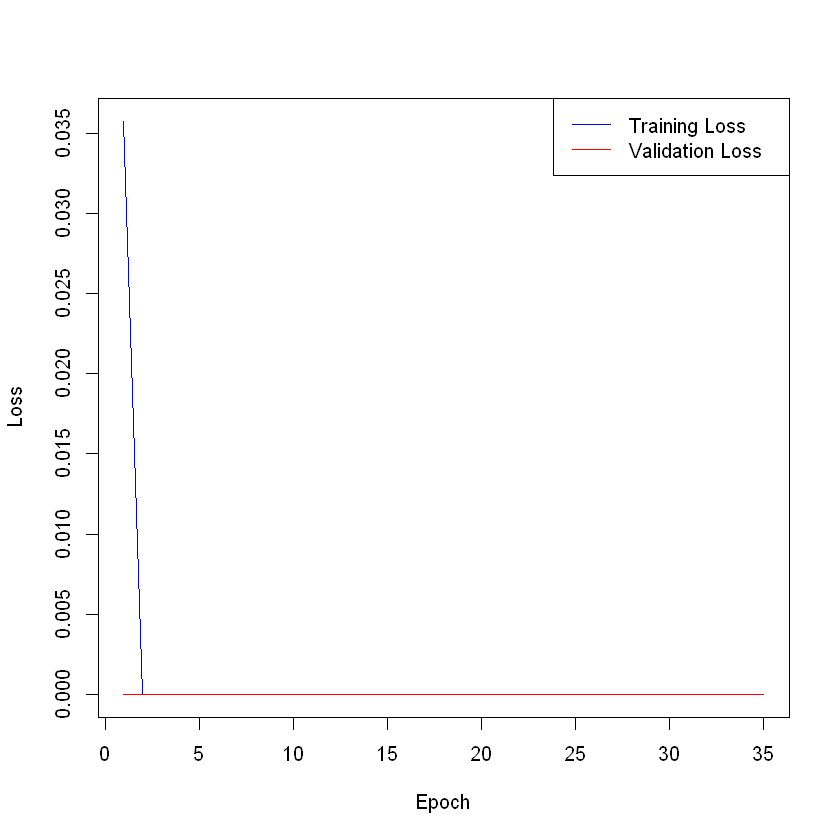

In [182]:

set.seed(101) 
train<-sample_frac(master, 0.7)
    sid<-as.numeric(rownames(train)) 
    test<-master[-sid,]

# building and loading the model
train_and_save_model_NN(train,"Model.h5")
model <- load_model_hdf5("Model.h5")

# encoding the dataset to out standards (one-hot and normalization)
test <- encode_categorical_variables(test,cat_cols,c("geo_level_2_id","geo_level_3_id"))
test <- encode_numerical_variables(test,c("count_floors_pre_eq","age","area_percentage","height_percentage"))

# damage_grade and building_id for later usage
true_damage <- test$damage_grade
building_ids <- test$building_id

# removing unused data
test$damage_grade <- NULL
test$building_id <- NULL

# predicting y using predict function (given as odds of outputs being 0,1 or 2)
predictions <- predict(model, as.matrix(test))



In [183]:
predicted_damage_grade <- max.col(predictions) + 1
#Formating csv for submission_format
df <- data.frame (building_id=building_ids,
                  damage_grade=predicted_damage_grade)
F1_Score_micro(true_damage,predicted_damage_grade)

[1] 0.5687388

## 3. Extra Learning Procedure: Gradient Boosting

As an additional learning procedure, a pure Gradient Boosting model was implemented. This decision was motivated by the fact that the Random Forest model took into account the class imbalance of the damage_grade variable. In this case, the focus is solely on analyzing the performance of a tree-based model.

Gradient Boosting, similar to Random Forest, is a powerful ensemble learning method that combines multiple weak learners, typically decision trees, to create a stronger model. By iteratively fitting new models to the residual errors of the previous models, Gradient Boosting gradually improves the overall prediction accuracy.

It is noteworthy that the Gradient Boosting model was also utilized for submission in the competition, resulting in a commendable accuracy of around **67%**. This underscores the effectiveness of the Gradient Boosting approach in addressing the classification problem at hand.

Warning message in train$damage_grade <- as.factor(as.character(train_data$damage_grade)):
"Coercing LHS to a list"
Warning message in test$damage_grade <- as.factor(as.character(test_data$damage_grade)):
"Coercing LHS to a list"
Warning message:
"Setting `distribution = "multinomial"` is ill-advised as it is currently broken. It exists only for backwards compatibility. Use at your own risk."
Warning message:
"Setting `distribution = "multinomial"` is ill-advised as it is currently broken. It exists only for backwards compatibility. Use at your own risk."
Warning message:
"Setting `distribution = "multinomial"` is ill-advised as it is currently broken. It exists only for backwards compatibility. Use at your own risk."
Warning message:
"Setting `distribution = "multinomial"` is ill-advised as it is currently broken. It exists only for backwards compatibility. Use at your own risk."
Warning message:
"Setting `distribution = "multinomial"` is ill-advised as it is currently broken. It exis

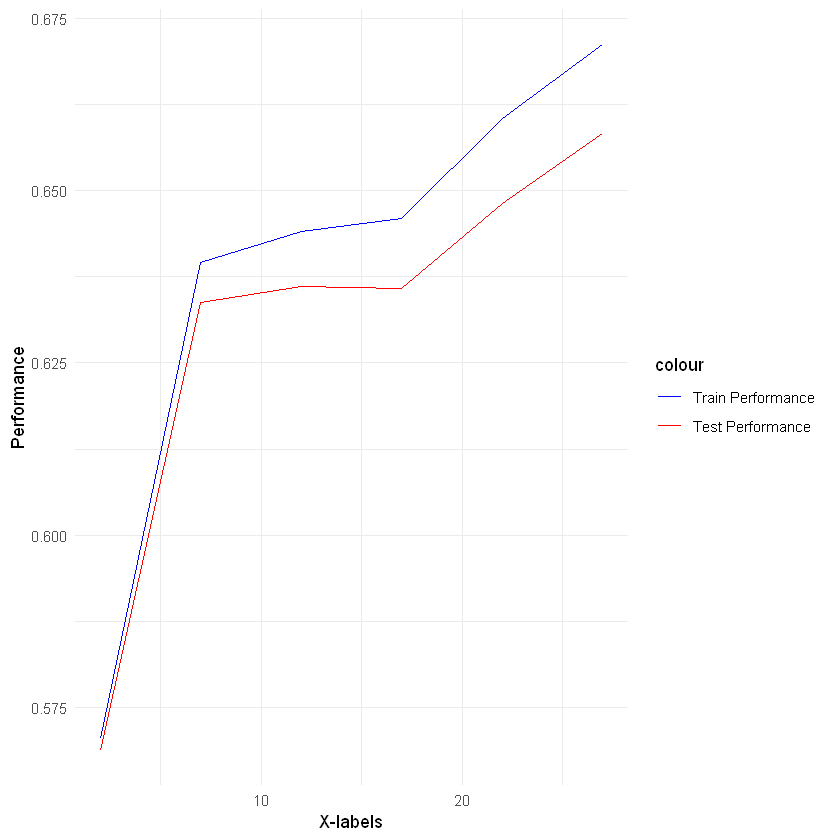

In [184]:
training(30, 'grad_boosting', 5)

## 4. Feature Relevance by "Conditional Entropy Ranking"

The conditional entropy algorithm utilizes two functions to derive feature relevance. Here is how each function operates:

- entropy: This function takes a vector of numbers, which will serve as the predictions in our case, and calculates the relative ratio of each outcome as a percentage of the total. These ratios are then used as probability estimates to compute the entropy. Entropy is a measure of uncertainty or randomness in a set of outcomes, and it quantifies the amount of information required to describe the outcome of a random variable.
- index_ranking: This function trains a complete model using "n_features" and trains additional models, each time excluding one of the features. For each model, the difference between its entropy and the entropy of the full model is calculated. The results are stored in a final dataframe, sorted in descending order of the differences.

By comparing the entropy differences, we can assess the impact of excluding each feature on the overall model entropy. This provides insight into the relevance and importance of each feature in the Random Forest model. The resulting ranking of features can aid in feature selection or determining which features contribute the most to the classification task.

In [185]:
entropy = function(data){
    # create the table of predictions with percentages
    y = as.data.frame(table(data))
    y$Freq = y$Freq / sum(y$Freq)

    # add a column for computing P(y)*log(P(y))
    y$ent = y$Freq*log(y$Freq)

    # entropy
    ent = -sum(y$ent)
    ent
}

index_ranking = function(train_data, test_data, n_features){
    # create a dataframe for the ranking
    ranking = data.frame(matrix(nrow = n_features, ncol = 1))
    rownames(ranking) = rownames(mi_df)[1:n_features]
    colnames(ranking) = 'Index'

    # let's store the variable we use in a dataframe
    df1 = train_data[rownames(mi_df)[1:n_features]]
    damage_grade = as.factor(as.character(train_data$damage_grade))
    df2 = test_data[rownames(mi_df)[1:n_features]]

    # train a full model
    random_for <- randomForest(damage_grade ~ ., data = df1, classwt = classwt, ntree=100)
    test_pred <- predict(random_for, df2, type='class') 
    entr_full = entropy(test_pred)

    for (i in 1:ncol(df1)){
        # remove the i-th feature
        random_for2 <- randomForest(damage_grade ~ ., data = df1[, -i], classwt = classwt, ntree=100)
        # Predict the labels for the test set
        test_pred2 <- predict(random_for, df2, type='class') 
        # compute the entropy without the i-th 
        entr_not_full = entropy(test_pred2)
        # index value
        ind = entr_not_full - entr_full
        # add in the ranking
        feature = rownames(mi_df)[i]
        ranking[i, 1] = ind
    }
    # see result
    ranking
    sorted_ranking <- arrange(ranking, desc(Index))
    sorted_ranking
}

index_ranking(train_data, test_data, 20)


,Index
,<dbl>
has_superstructure_rc_engineered,3.076426e-04
foundation_type_w,2.106104e-04
area_percentage,1.967388e-04
has_superstructure_cement_mortar_brick,1.380762e-04
has_superstructure_mud_mortar_stone,1.372793e-04
other_floor_type_s,1.167834e-04
foundation_type_i,1.066150e-04
ground_floor_type_v,1.042468e-04
geo_level_1_id_17,9.238501e-05


## 5. Submission Format
In this section, we will outline the routine for preprocessing the test set provided in the competition and generating the necessary estimates for the final submission.

In [186]:
# One-Hot Encoding
for (col in cat_cols) {
  dict <- unique(testset[[col]])
  binary_matrix <- matrix(0L, nrow = nrow(testset), ncol = length(dict))
  for (i in 1:length(dict)) {
    binary_matrix[testset[[col]] == dict[i], i] <- 1L
  }
  colnames(binary_matrix) <- paste0(col, "_", dict)
  testset <- cbind(testset, binary_matrix)
}

# remove the original categorical variables
testset = testset[, !colnames(testset) %in% cat_cols]

# let's store the variable we use in a dataframe
df1 = train_data[rownames(mi_df)[1:50]] 
damage_grade = as.factor(as.character(train_data$damage_grade))
df2 = testset[rownames(mi_df)[1:50]]
damage_grade1 = train_data$damage_grade

# Train gradient boosting gradient boosting
gbm_model <- gbm(damage_grade1 ~ ., data = df1, distribution = "multinomial", n.trees = 100, interaction.depth = 3, shrinkage = 0.1)

# Prediction 
pred = predict.gbm(object = gbm_model,
                newdata = df2,
                n.trees = 100,           
                type = "response")

Warning message:
"Setting `distribution = "multinomial"` is ill-advised as it is currently broken. It exists only for backwards compatibility. Use at your own risk."


In [187]:
# prediction formatting
labels = colnames(pred)[apply(pred, 1, which.max)]
test_pred = as.data.frame(labels)

# submission formatting
submission = data.frame(testset$building_id, test_pred)
colnames(submission) = c('building_id', 'damage_grade')
head(submission)
dim(submission)

,building_id,damage_grade
,<int>,<chr>
1,300051,3
2,99355,2
3,890251,2
4,745817,1
5,421793,3
6,871976,2


[1] 86868     2

# Improvements

1. Fixing overfitting problems with Neural-Network
2. Encoding geo_level 2 and 3
3. Fetching more types of data